UCI Appliances Energy Prediction

In [1]:
import pandas as pd

# Cargar los datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)

# Exploración inicial
print(data.head())
print(data.info())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility

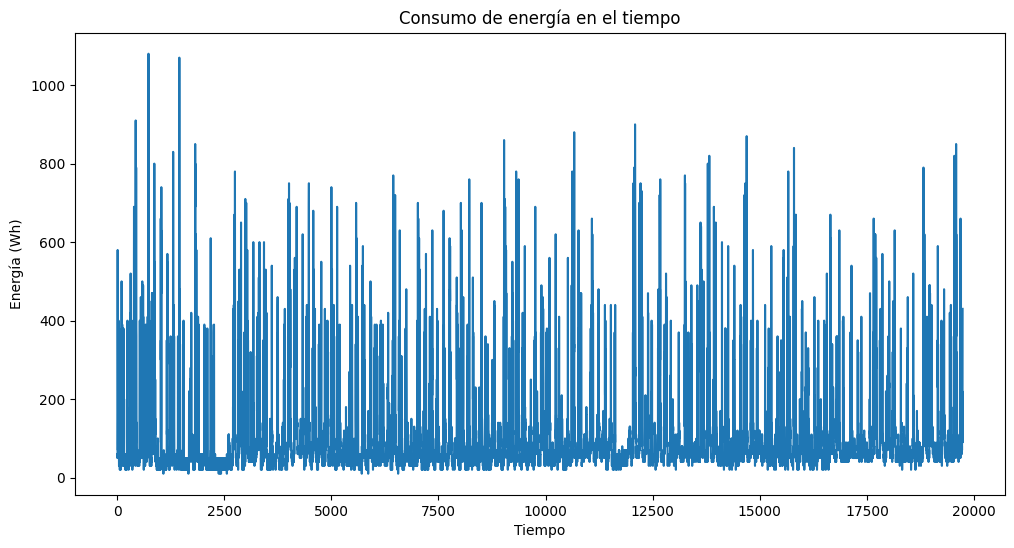

In [2]:
import matplotlib.pyplot as plt

# Visualizar el consumo de energía
data['Appliances'].plot(figsize=(12, 6))
plt.title("Consumo de energía en el tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Energía (Wh)")
plt.show()

In [3]:
# Convertir la columna de tiempo a formato datetime
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

<Axes: >

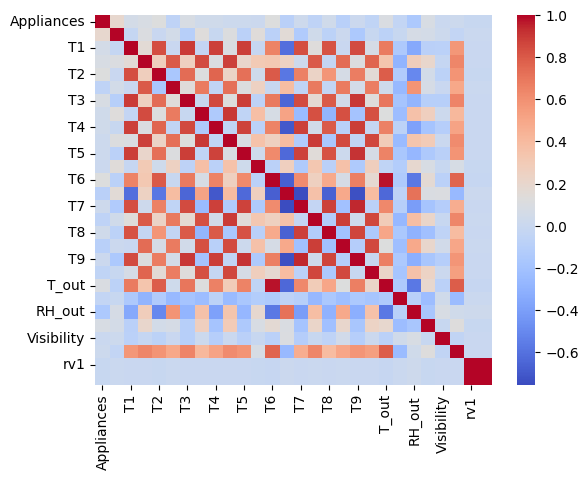

In [4]:
import seaborn as sns

# Matriz de correlación
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap="coolwarm")

In [5]:
# Selección de características y objetivo
features = data.drop(columns=['Appliances'])
target = data['Appliances']

# Normalización de los datos
from sklearn.preprocessing import StandardScaler

scaler_features = StandardScaler()
scaler_target = StandardScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [6]:
print(f"Media de las características escaladas: {features_scaled.mean(axis=0)}")
print(f"Desviación estándar de las características escaladas: {features_scaled.std(axis=0)}")
print(f"Media del objetivo escalado: {target_scaled.mean()}")
print(f"Desviación estándar del objetivo escalado: {target_scaled.std()}")

Media de las características escaladas: [ 0.00000000e+00  3.41031710e-15 -9.21707324e-17 -2.76512197e-16
  9.15946653e-16 -1.01387806e-15  2.04791846e-15 -7.83451225e-16
  7.08562505e-16  3.22597563e-16 -1.03692074e-16  4.60853662e-17
  1.15213415e-16  1.61298782e-15  9.79314032e-16  1.65907318e-15
  3.97486283e-16  8.29536591e-16 -1.16365550e-15 -1.38256099e-16
  1.30997653e-14 -2.18905489e-16  1.03692074e-16  1.15213415e-17
  9.21707324e-17  4.74355234e-17  4.74355234e-17]
Desviación estándar de las características escaladas: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
Media del objetivo escalado: 3.060356348599368e-17
Desviación estándar del objetivo escalado: 0.9999999999999999


In [7]:
import numpy as np

sequence_length = 72  # Ventana de pasos

def create_sequences(features, target, seq_length):
    X, Y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        Y.append(target[i+seq_length])
    return np.array(X), np.array(Y)

X, Y = create_sequences(features_scaled, target_scaled, sequence_length)

In [8]:
# División de datos
split = int(0.8 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

# Convertir a tensores de PyTorch
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [9]:
import torch
import math
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, seq_length):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=0.2, 
            batch_first=True  # Asegura que el formato sea [batch_size, seq_len, d_model]
            )
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.2)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.embedding = nn.Linear(input_dim, d_model)
        self.fc = nn.Linear(d_model, 1)
        self._create_positional_embeddings(seq_length, d_model)

    def _create_positional_embeddings(self, seq_length, d_model):
        position = torch.arange(0, seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_embed = torch.zeros(seq_length, d_model)
        pos_embed[:, 0::2] = torch.sin(position * div_term)
        pos_embed[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pos_embed)

    def forward(self, x):
        # Validar la longitud de la secuencia
        if x.shape[1] != self.seq_length:
            raise ValueError(f"La secuencia de entrada tiene longitud {x.shape[1]}, pero se esperaba {self.seq_length}")

        x = self.embedding(x)  # Proyección a d_model
        x = x + self.position_embedding  # Agregar información posicional
        x = self.transformer(x)  # [batch_size, seq_len, d_model]
        return self.fc(x[:, -1, :]).squeeze(-1)  # Reduce la dimensión extra para que sea [batch_size]

In [12]:
from torch.optim import AdamW

# Parámetros del modelo
input_dim = features.shape[1]  # Número de características
d_model = 128
nhead = 8
num_layers = 8

# Redefinir el modelo, pérdida y optimizador
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, sequence_length)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Configuración del entrenamiento
num_epochs = 100
train_losses = []
val_losses = []

/home/gmartinez/Deep-Learning-exercises/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Inicialización de Xavier
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)

TimeSeriesTransformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
   

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Crear DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

In [ ]:
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    scheduler.step(val_loss)  # Reducir la tasa de aprendizaje

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Graficar pérdidas
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()

/home/gmartinez/Deep-Learning-exercises/.venv/lib64/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/gmartinez/Deep-Learning-exercises/.venv/lib64/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Train Loss: 1.0872, Val Loss: 0.7740
Epoch 2/100, Train Loss: 1.0811, Val Loss: 0.7561
Epoch 3/100, Train Loss: 1.0774, Val Loss: 0.7764
Epoch 4/100, Train Loss: 1.0773, Val Loss: 0.7538
Epoch 5/100, Train Loss: 1.0736, Val Loss: 0.7582
Epoch 6/100, Train Loss: 1.0683, Val Loss: 0.7543
Epoch 7/100, Train Loss: 1.0675, Val Loss: 0.7622
